
<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# PyTorch implementation of Generative Adversarial Networks #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Some ideas by Xiaobo Dong

Copyright 2022 University of Illinois Board of Trustees. All Rights Reserved.

Pytorch documentation: <https://pytorch.org/docs/stable/index.html>

# imports and graphics configurations #

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import sklearn.linear_model
import sklearn.model_selection
import itertools


def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
import torch
import scipy

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
#print([os.remove(f) for f in pngfiles])

existing png files: []


In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

# configuration variables #

In [ ]:
SEED=0
fakecolor="red"
truecolor="blue"
policecolor="#49796B"

# main #

In [ ]:
N_points=250

In [ ]:
(m,b)=(2,1)
(xlocation,xscale)=(-1,1)
yscale=0.1

Let's create a point cloud around the line y=mx+b where m=2 and b=1
Let's take the x values of our cloud to be Gaussian with mean -1 and standard deviation 1.  Our point cloud will have standard deviation 0.1

In [ ]:
def line(x):
  return m*x+b

In [ ]:
numpy.random.seed(SEED)
xpoints=scipy.stats.norm.rvs(size=N_points,loc=xlocation,scale=xscale)
ypoints=line(xpoints)+scipy.stats.norm.rvs(size=N_points,scale=yscale)
data=list(zip(xpoints,ypoints))

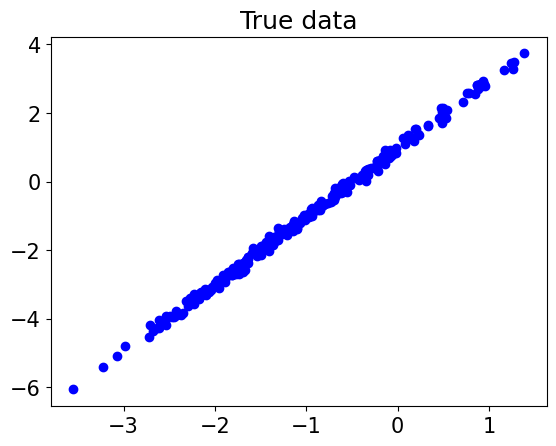

In [ ]:
(x,y)=zip(*data)
plt.figure()
plt.scatter(x,y,color=truecolor)
(XA,XB)=plt.xlim()
(YA,YB)=plt.ylim()
title=[]
title.append("True data")
plt.title("\n".join(title))
saver("points")
plt.show()
plt.close()

## Implement with PyTorch ##

In [ ]:
true_data=torch.from_numpy(numpy.array(data).astype(numpy.float32))
true_data=true_data.cuda() if torch.cuda.is_available() else true_data

In [ ]:
learningRate=0.075
Noise_Dim=1

In [ ]:
class generator(torch.nn.Module):
    def __init__(self,inputSize=1,outputSize=1,SEED=0): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        if SEED is not None:
          torch.manual_seed(SEED)
        self.linear = torch.nn.Linear(inputSize,outputSize)
        if torch.cuda.is_available():
          self=self.cuda()

    def forward(self, x):
        out=self.linear(x)
        return out

G=generator(inputSize=Noise_Dim,outputSize=2) #map two-dimensional noise into two-dimensional counterfeit

In [ ]:
class discriminator_1(torch.nn.Module):
    def __init__(self,inputSize=1,outputSize=1,internalSize=1,SEED=0): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        if SEED is not None:
          torch.manual_seed(SEED)
        self.linear1 = torch.nn.Linear(inputSize,internalSize)
        self.linear2 = torch.nn.Linear(internalSize,internalSize)
        self.linear3 = torch.nn.Linear(internalSize,outputSize)
        self.relu=torch.nn.ReLU()
        self.sigmoid=torch.nn.Sigmoid()
        if torch.cuda.is_available():
          self=self.cuda()

    def forward(self, x):
        out=x
        out=self.relu(self.linear1(out))
        out=self.relu(self.linear2(out))
        out=self.sigmoid(self.linear3(out))
        return out

#D=discriminator_1(inputSize=2,outputSize=1,internalSize=5) #map two-dimensional noise into one-dimensional probability

In [ ]:
class discriminator_2(torch.nn.Module):
    def __init__(self,SEED=0): #default to one-dimensional feature and response
        super().__init__() #run init of torch.nn.Module
        if SEED is not None:
          torch.manual_seed(SEED)
        self.linearx = torch.nn.Linear(1,1)
        self.linearboth = torch.nn.Linear(2,1)
        self.sigmoid=torch.nn.Sigmoid()
        if torch.cuda.is_available():
          self=self.cuda()

    def bump(self,x):
          return self.sigmoid(x+1)*(1-self.sigmoid(x-1))

    def forward(self, x):
        (xx,_)=torch.split(x,[1,1],dim=1)
        transformedx=self.linearx(xx) #how to center x
        to_line=self.linearboth(x) #where is line
        out=self.bump(transformedx)*self.bump(to_line)
        return out

D=discriminator_2()

In [ ]:
Loss = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters())
optimizer_D = torch.optim.Adam(D.parameters())

In [ ]:
def visualize():
    G.eval()
    z = torch.randn(size=(100,Noise_Dim))
    newpoints=G(z).detach().numpy()
    (xnew,ynew)=zip(*newpoints)
    plt.figure()
    plt.scatter(x,y,color=truecolor,label="True data")
    plt.scatter(xnew,ynew,color="red",label="Generated Data")
    title=[]
    title.append("GAN data")
    try:
      (m_1,m_2)=G.linear.weight.data.squeeze().numpy()
      (b_1,b_2)=G.linear.bias.data.numpy()
      title.append("generative line is  {0:.2f}x{1:+.2f}".format(m_2/m_1,b_2-m_2/m_1*b_1))
    except Exception:
      pass
    plt.title("\n".join(title))
    legend("bottom")
    plt.show()
    plt.close()

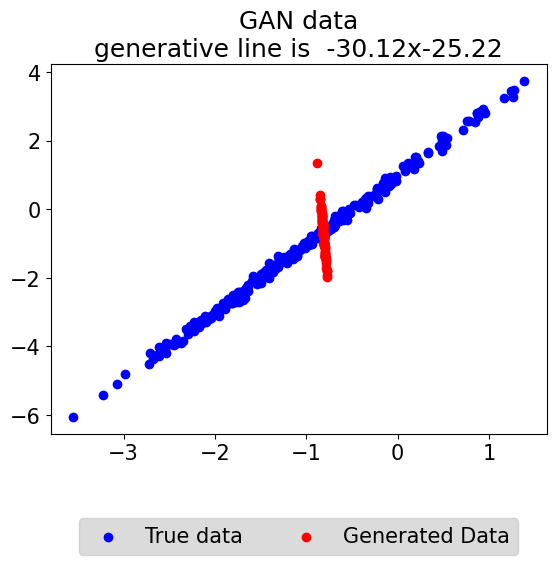

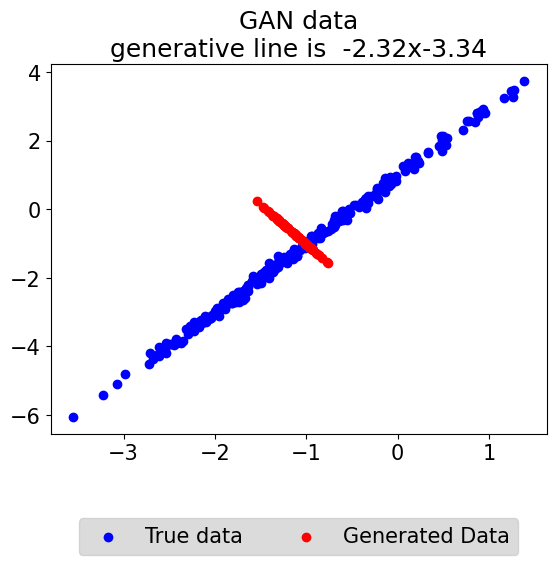

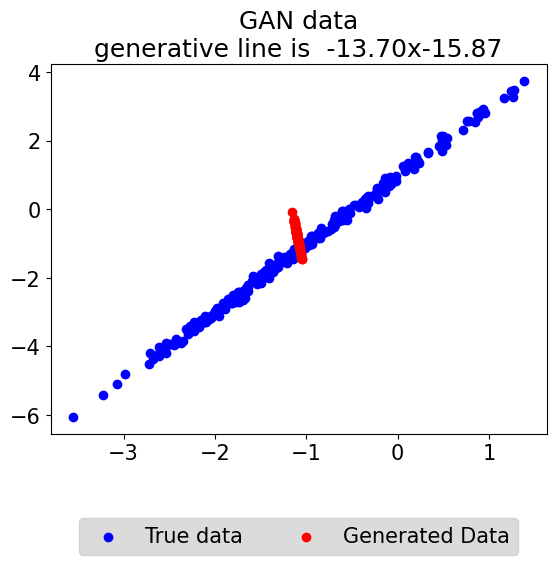

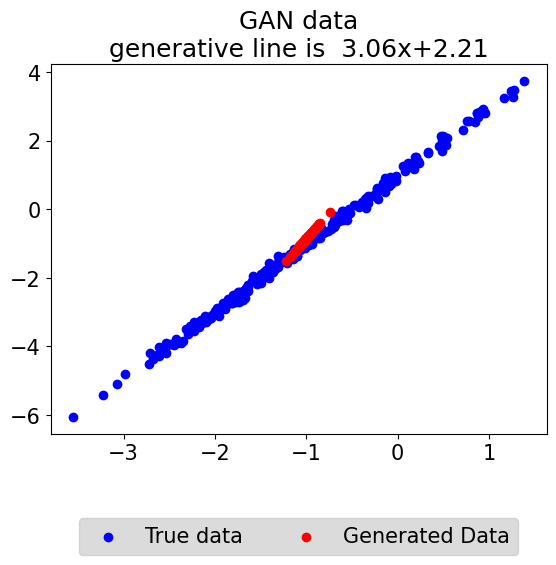

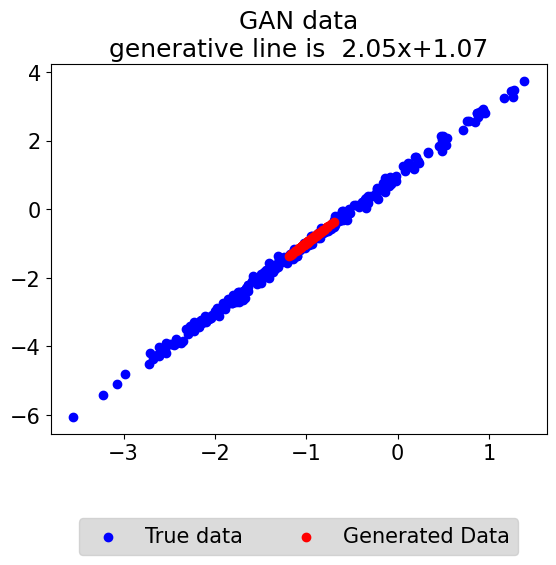

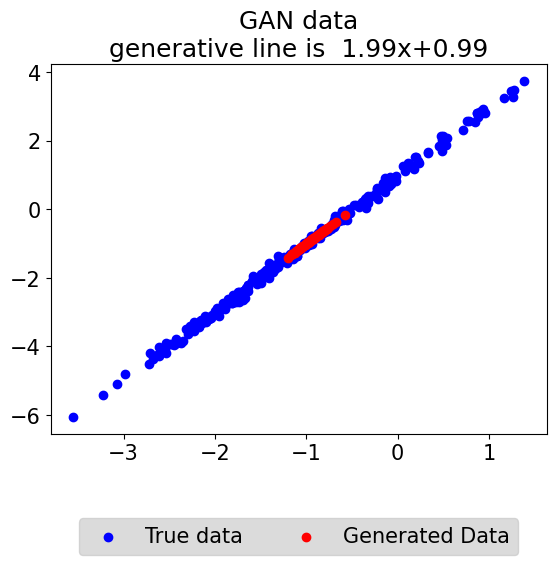

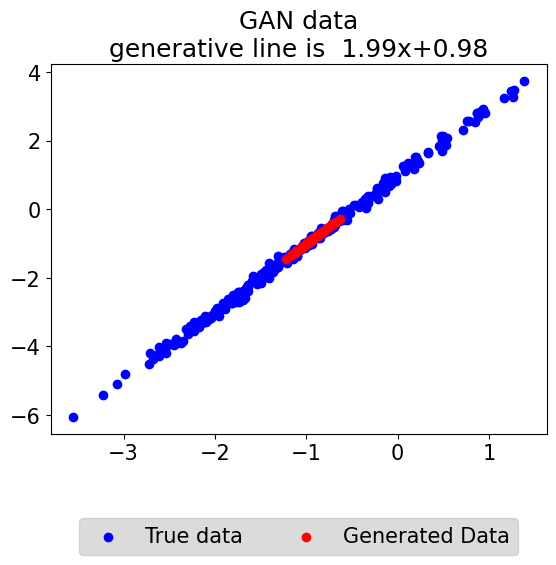

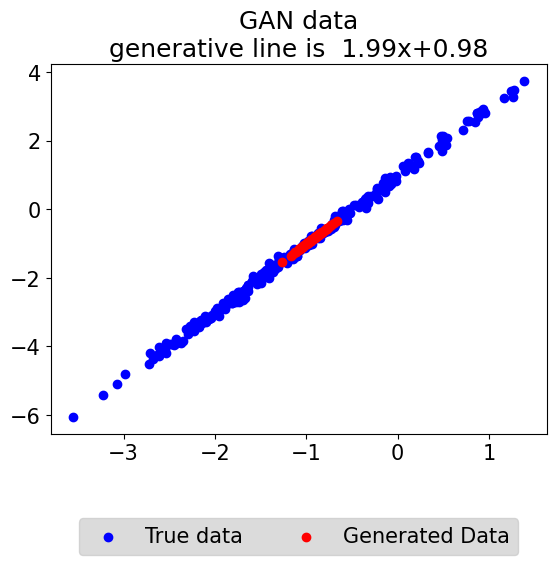

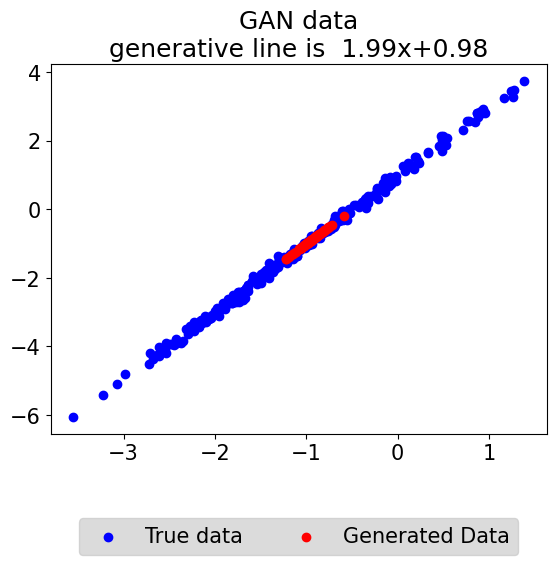

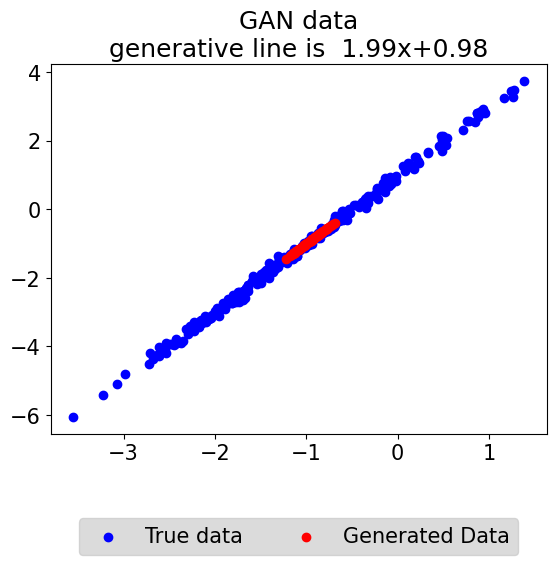

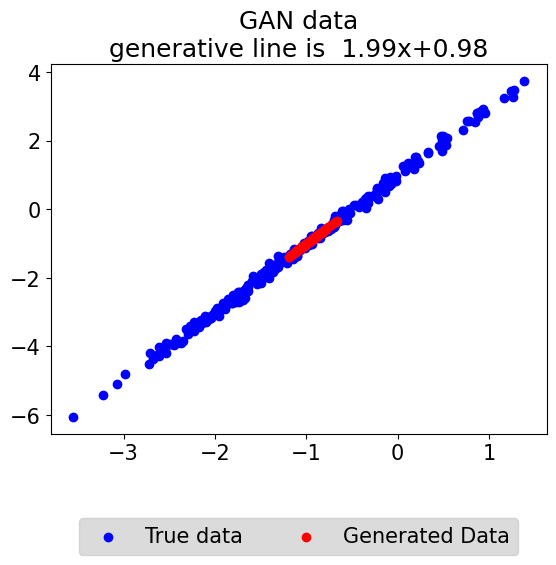


execution time: 38.07321 seconds


In [ ]:
MAX_iter_outside = 1000
MAX_iter_inside=10
Noise_Length=N_points
starttime=time.time()
for itr in range(MAX_iter_outside+1):
    newNoise=torch.randn(size=(Noise_Length,Noise_Dim))

    #minimize over discriminator
    #fix coefficients of CounterFeiter
    G.train()
    D.eval()
    for itr_inside in range(MAX_iter_inside):
      #newNoise=torch.randn(size=(Noise_Length,Noise_Dim))
      optimizer_D.zero_grad()
      GeneratedData=G(newNoise)
      totalData=torch.cat([true_data,GeneratedData],dim=0)
      totalLabels=torch.cat((torch.ones((len(true_data),1)),torch.zeros(len(GeneratedData),1)),dim=0) #could be done outside of loop
      temp=D(totalData)
      t=Loss(temp,totalLabels)
      t.backward()
      optimizer_D.step()

    #maximize over generator
    #fix coefficients of Detective
    G.train()
    D.eval()
    for itr_inside in range(MAX_iter_inside):
      #newNoise=torch.randn(size=(Noise_Length,Noise_Dim))
      optimizer_G.zero_grad()
      GeneratedData=G(newNoise)
      totalData=torch.cat([true_data,GeneratedData],dim=0)
      totalLabels=torch.cat((torch.ones((len(true_data),1)),torch.zeros(len(GeneratedData),1)),dim=0) #could be done outside of loop
      temp=D(totalData)
      t=-Loss(temp,totalLabels)
      t.backward()
      optimizer_G.step()

    if itr%int(MAX_iter_outside/10)==0:
      visualize()


endtime=time.time()
print("\nexecution time: {0:.5f} seconds".format(endtime-starttime))

Generative procedure is to take one-dimensional noise into two-dimensional line;
$$ z\mapsto \begin{pmatrix} m_1z+b_1 \\ m_2z+b_2 \end{pmatrix}$$
Writing
$$ x=m_1z+b_1 \qquad \text{and}\qquad y=m_2z+b_2 $$
we have
\begin{align*} y=m_2z+b_2 &= \frac{m_2}{m_1}(m_1z+b_1)+\left(b_2-\frac{m_2}{m_1}b_1\right) \\
&=mx+b \end{align*}
where
$$ m=\frac{m_2}{m_1} \qquad \text{and}\qquad b=b_2-\frac{m_2}{m_1}b_1 $$


In [ ]:
(m_1,m_2)=G.linear.weight.data.squeeze().numpy()
(b_1,b_2)=G.linear.bias.data.numpy()
print("generative line is  {0:.2f}x+{1:.2f}".format(m_2/m_1,b_2-m_2/m_1*b_1))

generative line is  1.99x+0.98
